In [35]:
import pandas as pd
import numpy as np

# hidpi figures
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

In [36]:
filename='/Users/wittich/Downloads/012(2).csv'

The data file is expected to have a format like this:
```
% head muon_data_20241101_1806.csv
baseline,stddev,threshold,reset_threshold,run_start_time,is_leader
775.0, 9.3, 975, 825, 2024-11-01T18:06:41.482495-04:00, 1
Muon Count,ADC,temperature_ADC,dt,t,t_wait,coinc
1, 7089, 15171, 2, 20751, 76, 0
2, 5313, 15171, 240, 20991, 78, 0
3, 1024, 15171, 580, 21571, 93, 0
```
Metadata about the run in the first two lines, then the header for the actual data, followed by the data.

First, read in the first two rows of the CSV file: they contain metadata about the run itself. Start time, thresholds, if the device is the 'leader'.

Put the file name in here.

Skipping the first two rows which contain the metadata,read in the rest of the CSV file. 
Concert the two ADC counts to volts and temperature, respectively.

In [37]:
df = pd.read_csv(filename,sep=',',engine='python')
print(df.keys())
if 'muon_count' in df.keys():
    df=df.drop(columns=['muon_count'])
print(len(df))
df['V'] = df['adc_v']*3.3/(2**16-1)
## Convert 16-bit ADC value to degrees C for a TMP36 temperature sensor -- Rev2
#df['TempC'] = (df['temperature_ADC']*3.3/65536)/.01 + (25-75)
# Rev 3 -- TMP235 sensor
# data sheet page 8, T_A = (V_OUT - V_OFFSET)/T_C + T_INFL
# for the TMP235, V_OUT = T_C = 10 mV/degC and V_OFFSET = 500 mV, for 
# the temperature range -40C to 100C. T_INFL = 0
T_INFL = 0.
T_C = 0.01 # 10 mV/degC
V_OFFSET = 0.5 # 500 mV
df['TempC'] = ((df['temp_adc_v']*3.3/65536)  - V_OFFSET)/T_C + T_INFL
df.head()

Index(['device_id', 'ts', 'device_number', 'muon_count', 'adc_v', 'temp_adc_v',
       'dt', 'wait_cnt', 'coincidence'],
      dtype='object')
150119


,device_id,ts,device_number,adc_v,temp_adc_v,dt,wait_cnt,coincidence,V,TempC
0,12,2026-01-07T17:46:03+00:00,12,24565,14563,0,70,False,1.236965,23.330536
1,12,2026-01-07T17:46:04+00:00,12,3392,14595,0,104,False,0.170803,23.491669
2,12,2026-01-07T17:46:04+00:00,12,23605,14595,0,71,False,1.188624,23.491669
3,12,2026-01-07T17:46:06+00:00,12,23589,14611,0,71,False,1.187819,23.572235
4,12,2026-01-07T17:46:07+00:00,12,11538,14435,0,83,False,0.580993,22.686005


In [38]:
# ts is the timestamp in UTC in ISO 8601 format
df['ts'] = pd.to_datetime(df['ts'], format='ISO8601', utc=True)
df = df.set_index('ts')
df = df.sort_index()
df.head()

,device_id,device_number,adc_v,temp_adc_v,dt,wait_cnt,coincidence,V,TempC
ts,,,,,,,,,
2026-01-07 17:46:03+00:00,12,12,24565,14563,0,70,False,1.236965,23.330536
2026-01-07 17:46:04+00:00,12,12,3392,14595,0,104,False,0.170803,23.491669
2026-01-07 17:46:04+00:00,12,12,23605,14595,0,71,False,1.188624,23.491669
2026-01-07 17:46:06+00:00,12,12,23589,14611,0,71,False,1.187819,23.572235
2026-01-07 17:46:07+00:00,12,12,11538,14435,0,83,False,0.580993,22.686005


In [39]:
df.keys()

Index(['device_id', 'device_number', 'adc_v', 'temp_adc_v', 'dt', 'wait_cnt',
       'coincidence', 'V', 'TempC'],
      dtype='object')

Look at the correlation between t_wait and the measured threshold. 

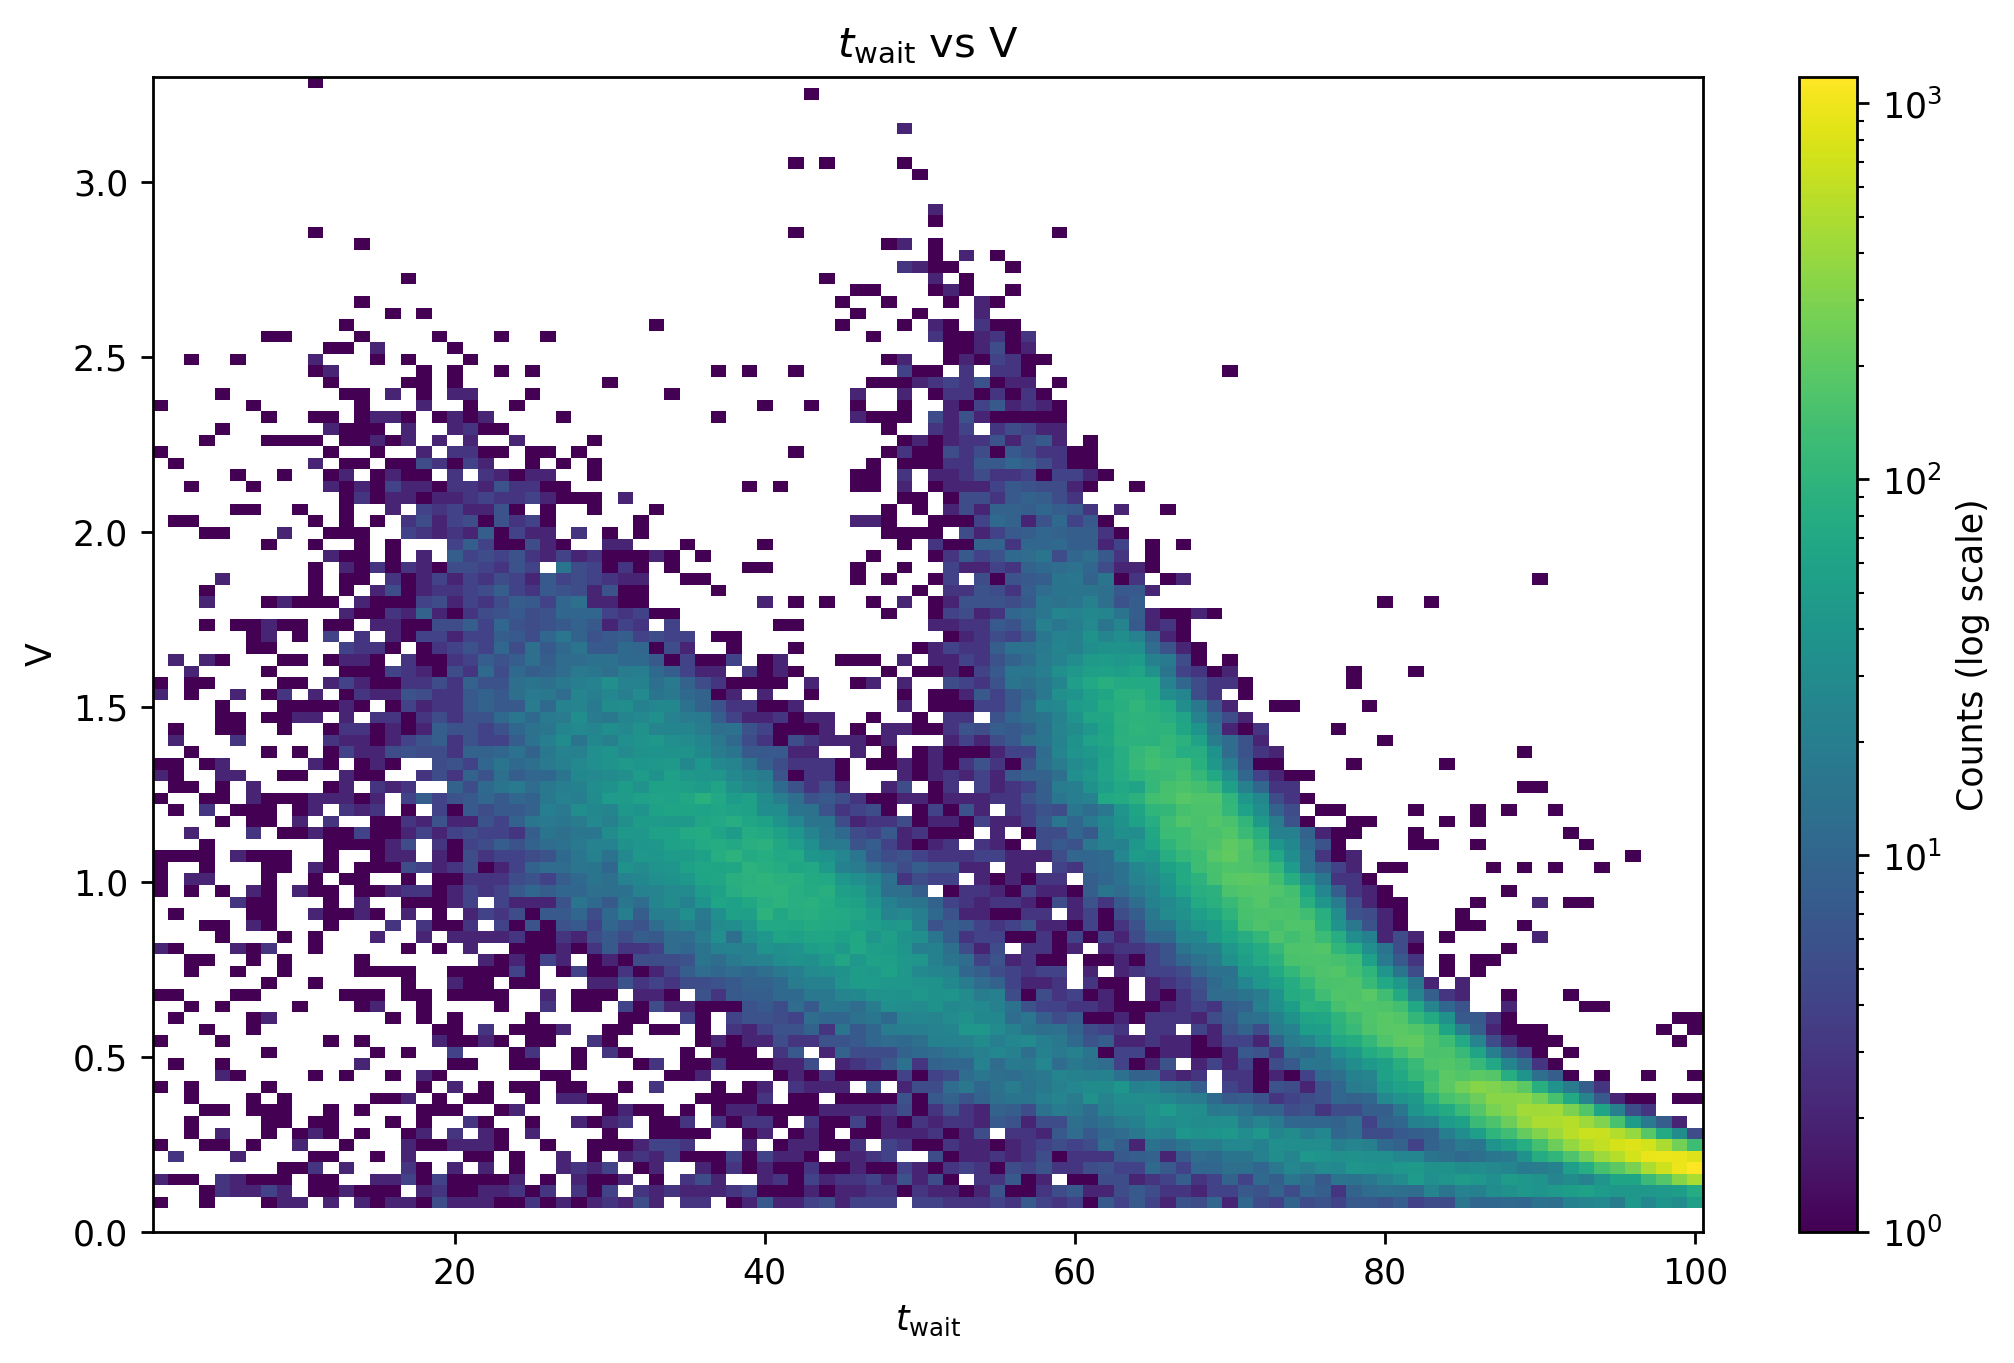

In [40]:
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 6))
tedges = np.linspace(30.5, 100.5, 71)
tedges = np.linspace(0.5, 100.5, 101)
vedges = np.linspace(0, 3.3, 101)
plt.hist2d(df['wait_cnt'], df['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm())
plt.colorbar(label='Counts (log scale)')
plt.xlabel('$t_\\text{wait}$')
plt.ylabel('V')
plt.title('$t_\\text{wait}$ vs V')
plt.show()

# Create two different subsets of the full data file:
## dfc
This is the dataframe with a twait cut. this uses $t_{wait}$ as a proxy for the time it takes to return to baseline; should reject noise injected after the peak detector. Choose t_wait cut based on the plot above.

Note that twait is odd: it starts at 100 and counts downward. so t_wait is 60 means the code waited 40 loop iterations (100-60).
## dfcc 
This is the file with a coincidence requirement between two detectors. Should reject singles rate.

Total entries: 150119, Entries with wait_cnt < 60: 30177


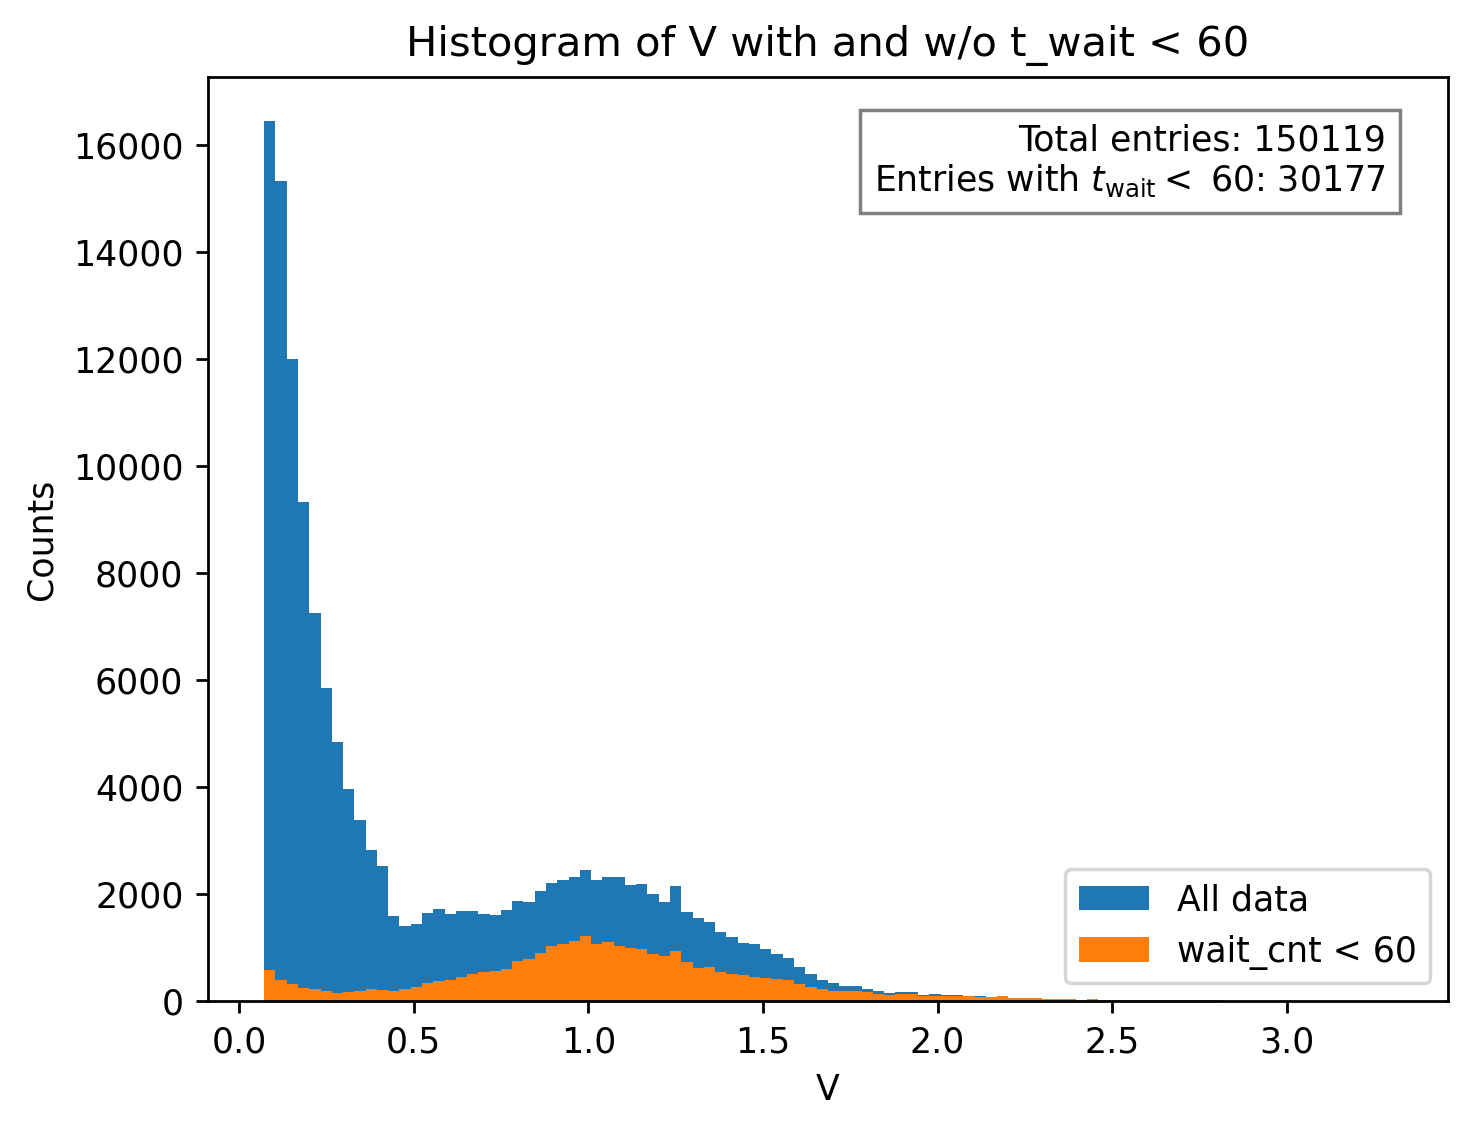

<Figure size 1600x1200 with 0 Axes>

In [41]:
cut = 60
dfc = df[df['wait_cnt'] < cut].copy()
df['V'].plot.hist(bins=100)
dfc['V'].plot.hist(bins=100)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title(f'Histogram of V with and w/o t_wait < {cut}')
plt.legend(['All data', f'wait_cnt < {cut}'])
total_entries = len(df)
cut_entries = len(df[df['wait_cnt'] < cut])
print(f'Total entries: {total_entries}, Entries with wait_cnt < {cut}: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with $t_\\text{{wait}}<$ {cut}: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()
plt.savefig('V_hist.png')


Total entries: 150119, Entries with coincidence: 28553


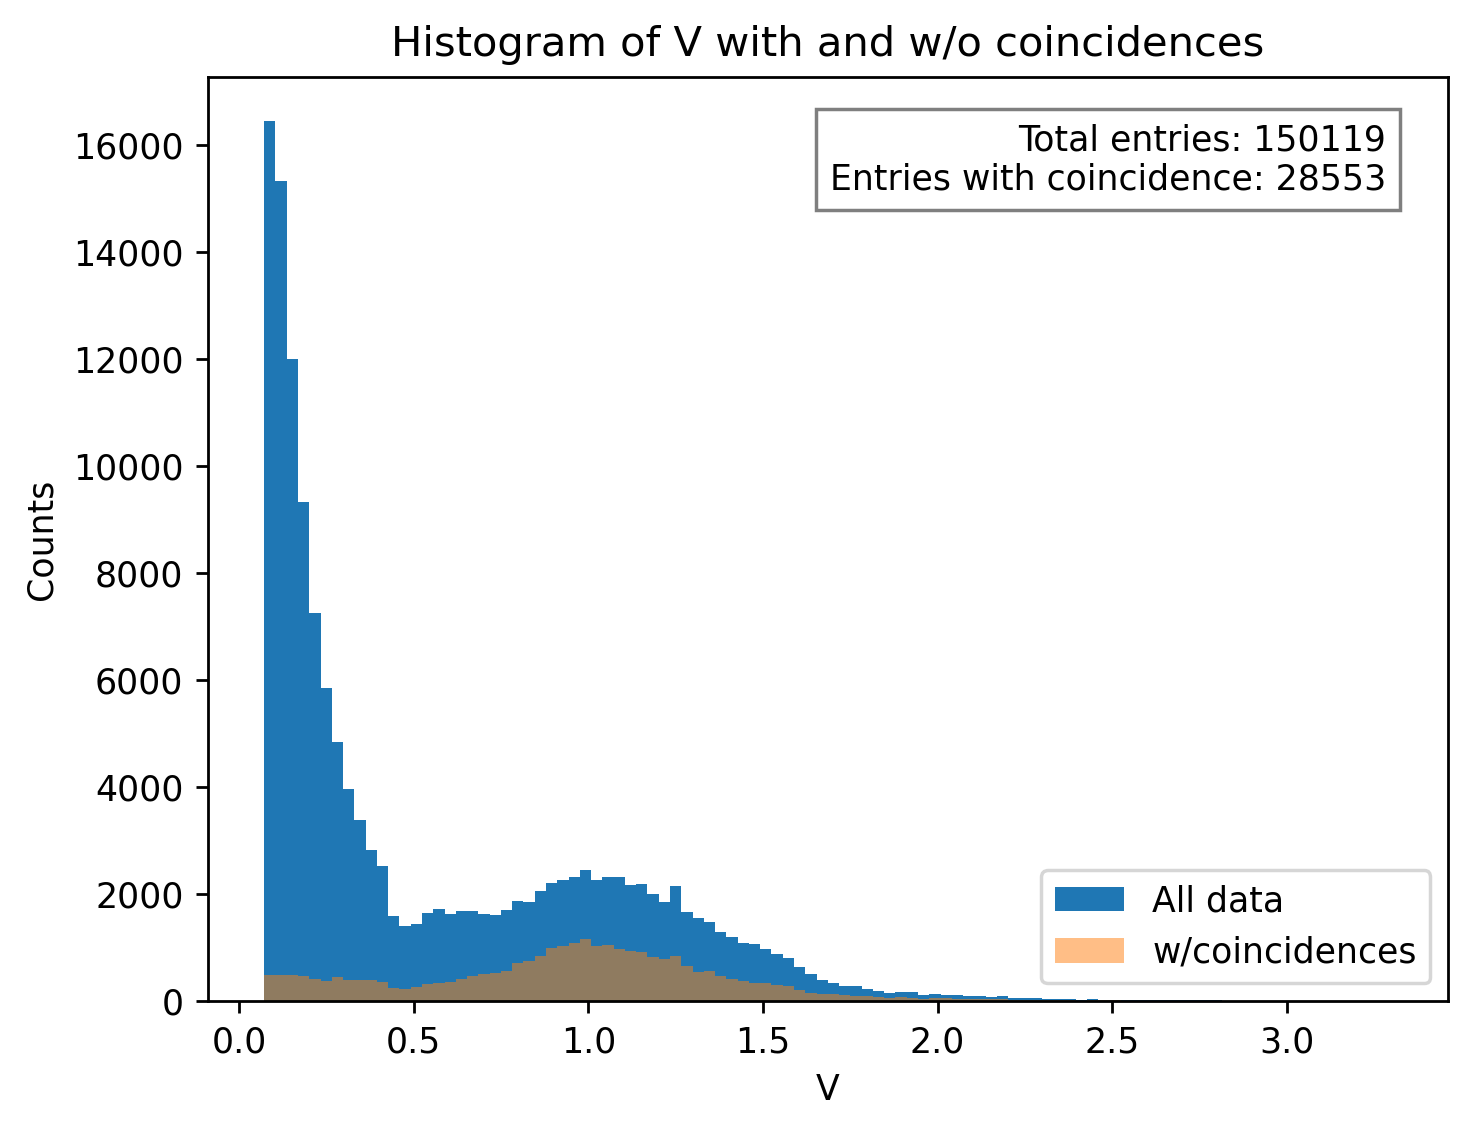

<Figure size 1600x1200 with 0 Axes>

In [42]:
dfcc = df[df['coincidence'] >0].copy()
df['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title('Histogram of V with and w/o coincidences')
plt.legend(['All data', 'w/coincidences'])
total_entries = len(df)
cut_entries = len(dfcc)
print(f'Total entries: {total_entries}, Entries with coincidence: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with coincidence: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()
plt.savefig('V_hist_coinc.png')

Total entries: 150119, Entries with coincidence: 28553


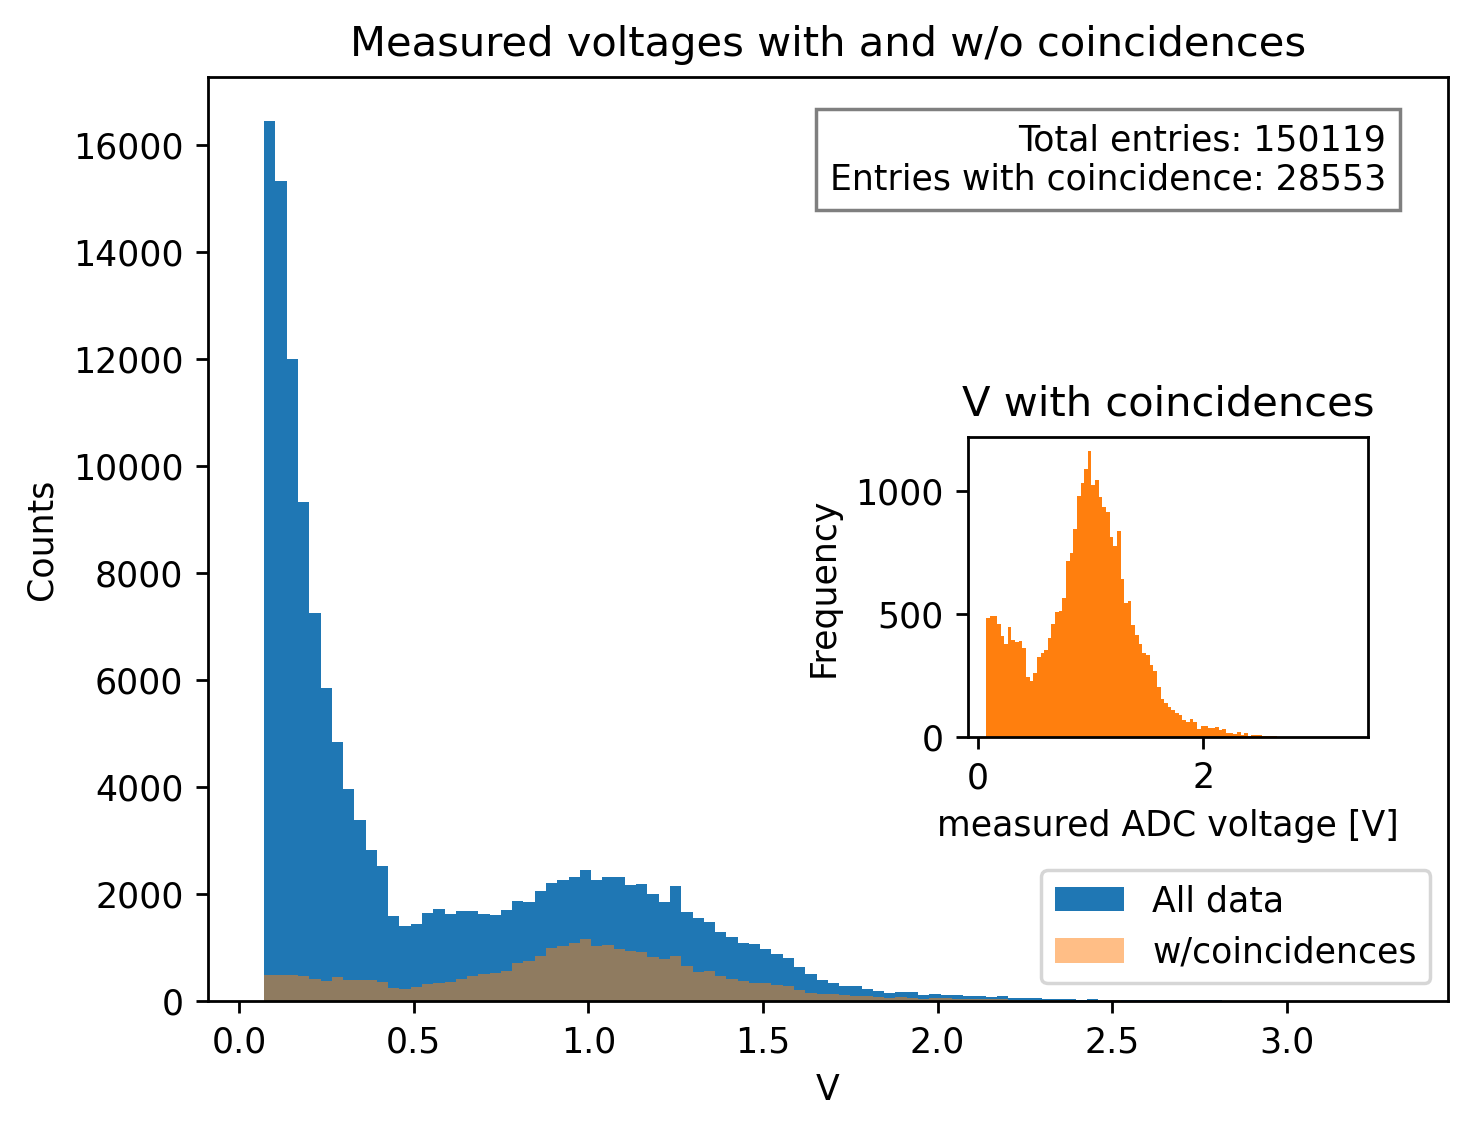

<Figure size 1600x1200 with 0 Axes>

In [43]:
dfcc = df[df['coincidence'] >0].copy()
df['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.title('Measured voltages with and w/o coincidences')
plt.legend(['All data', 'w/coincidences'])
total_entries = len(df)
cut_entries = len(dfcc)
print(f'Total entries: {total_entries}, Entries with coincidence: {cut_entries}')
plt.text(0.95, 0.95, f'Total entries: {total_entries}\nEntries with coincidence: {cut_entries}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
# add an inset with the histogram of the coincidences
axin = plt.axes([0.6, 0.33, 0.25, 0.25])
dfcc['V'].plot.hist(bins=100, color='C1', ax=axin)
plt.title('V with coincidences')
plt.xlabel('measured ADC voltage [V]')
plt.show()
plt.savefig('V_hist_coinc_inset.png')

Compare the two ways of rejecting noise. 

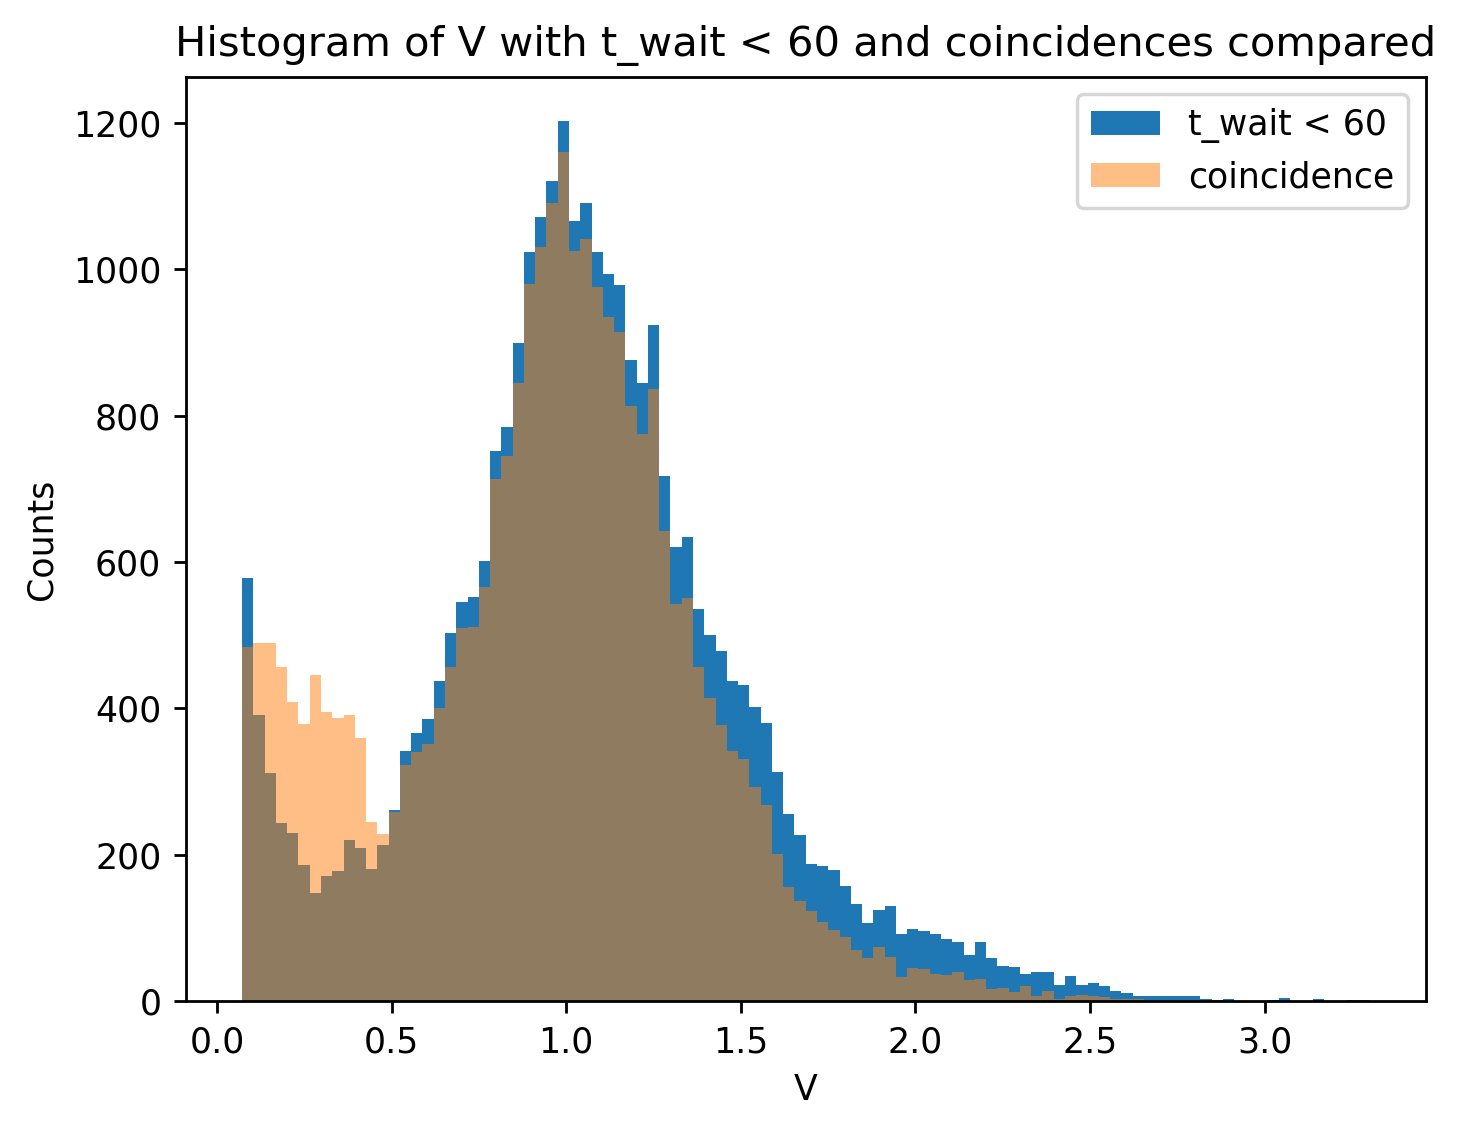

In [44]:
dfc['V'].plot.hist(bins=100)
dfcc['V'].plot.hist(bins=100, alpha=0.5)
plt.xlabel('V')
plt.ylabel('Counts')
plt.legend([f't_wait < {cut}', 'coincidence'])
plt.title(f'Histogram of V with t_wait < {cut} and coincidences compared')
plt.savefig('V_hist_coinc_twait.png')

Text(0.95, 0.95, 'Number of entries: 28553')

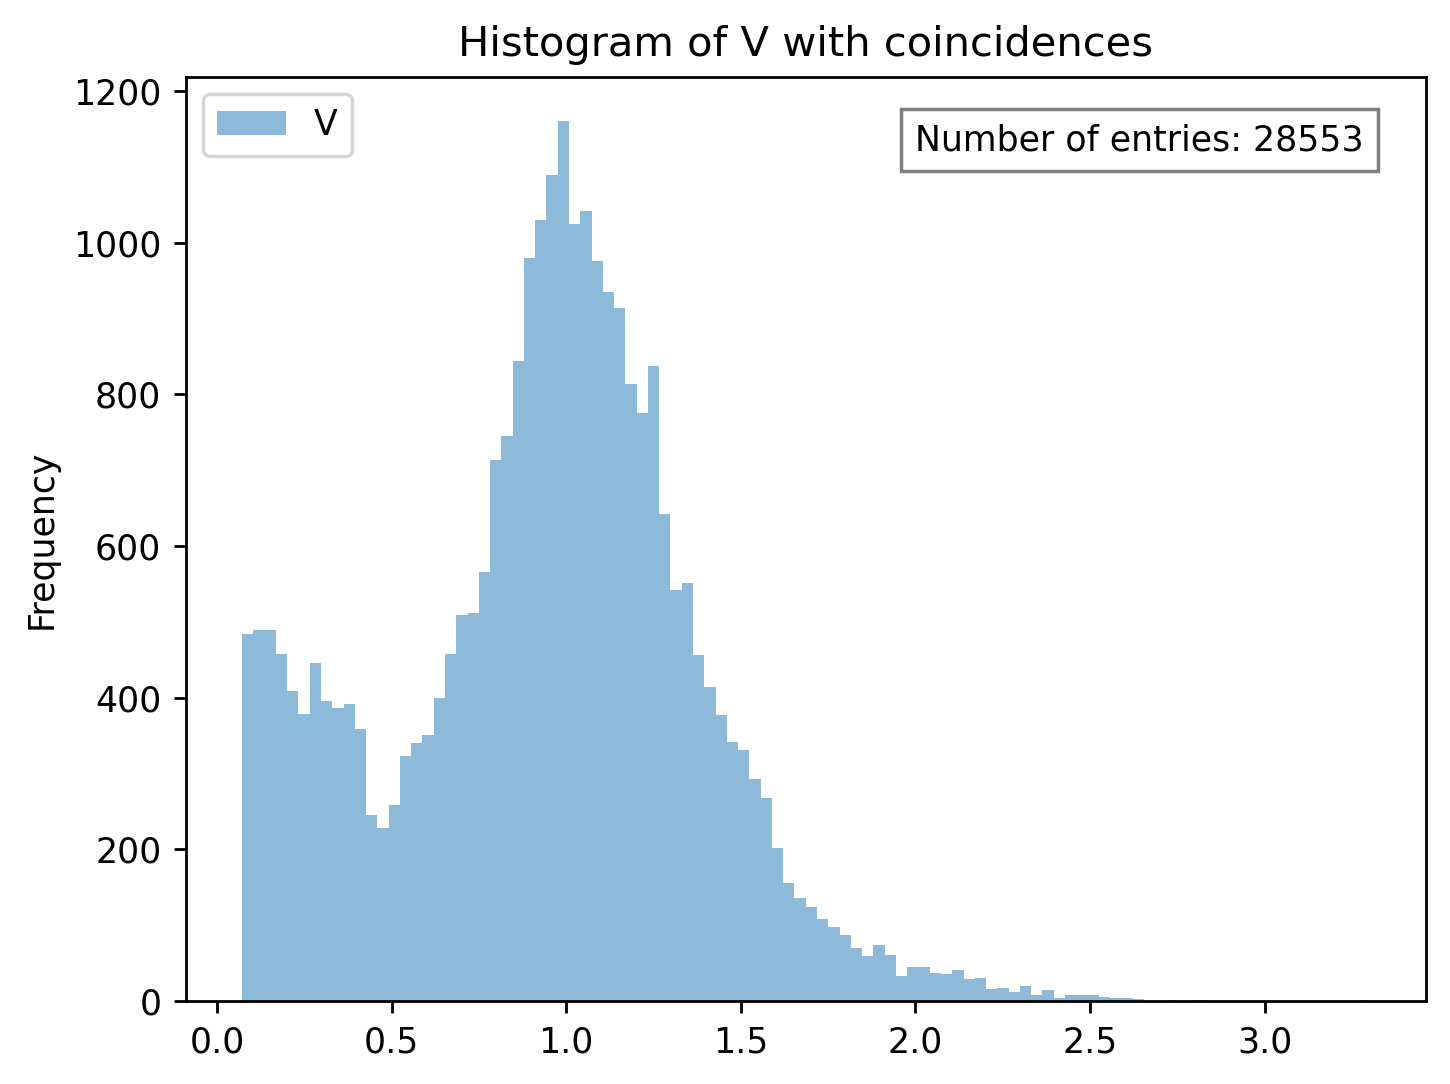

In [45]:
dfcc.plot.hist(y='V', bins=100, alpha=0.5, label='V')
plt.title('Histogram of V with coincidences')
ncount = len(dfcc)
plt.text(0.95, 0.95, f'Number of entries: {ncount}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

Text(0, 0.5, 'Counts')

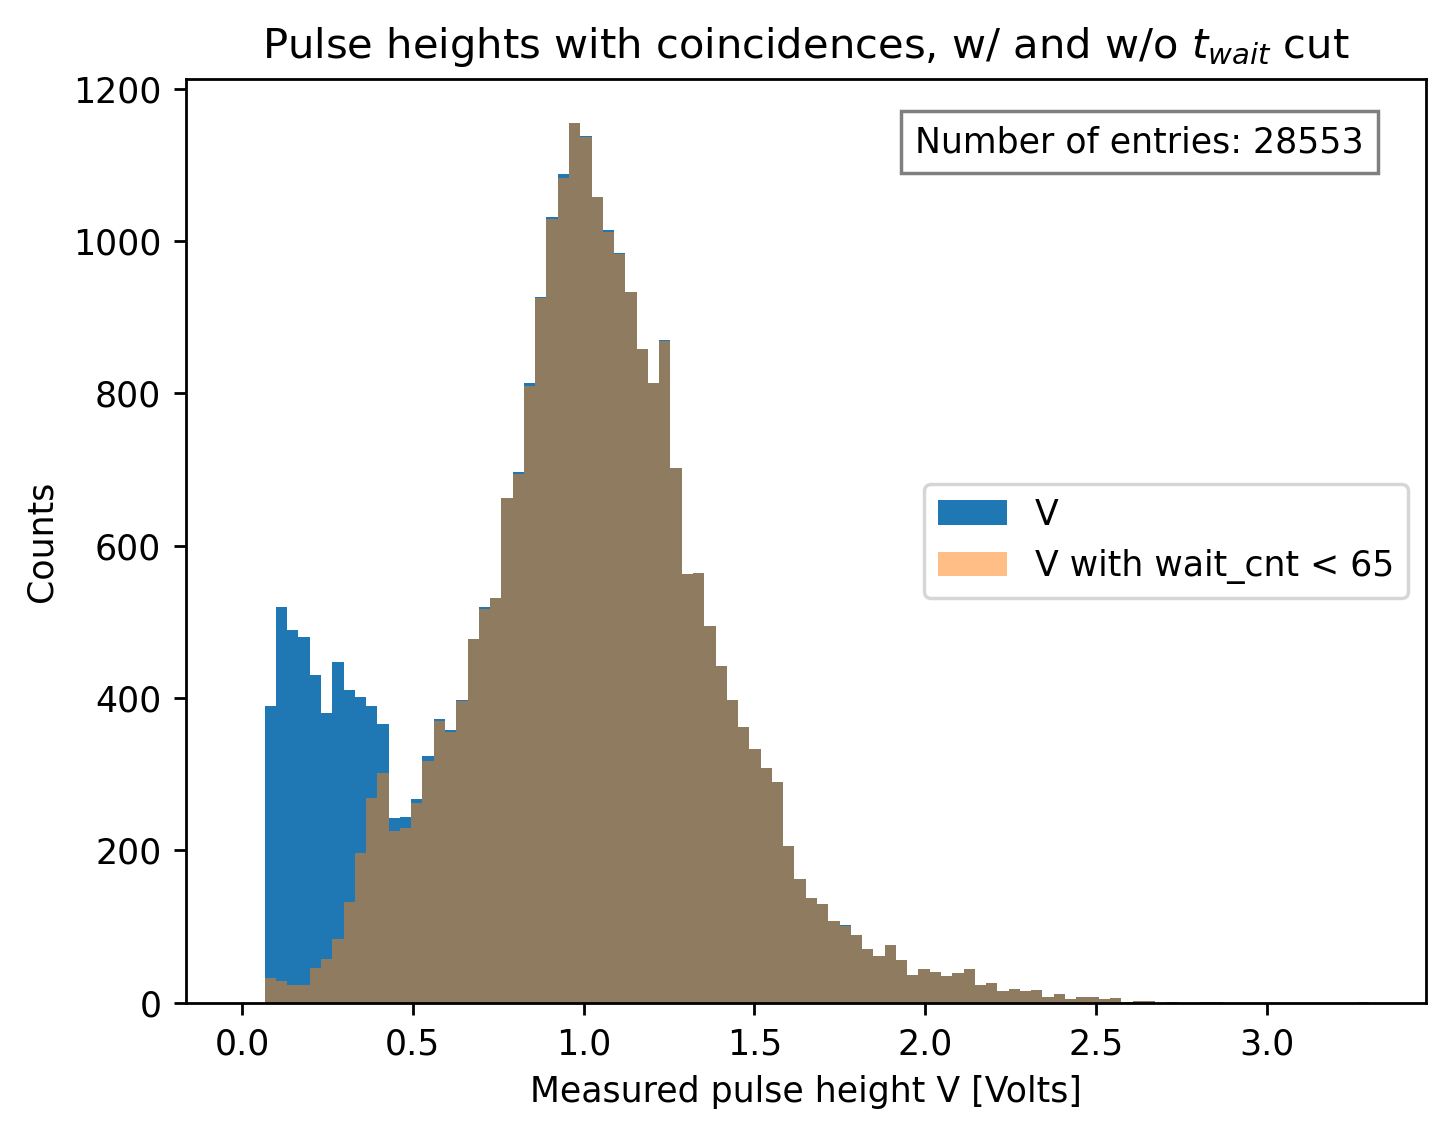

In [46]:
cut=65
dfcc['V'].plot.hist(label='V', bins=100, range=(0, 3.3))
dfcc[dfcc['wait_cnt']<cut]['V'].plot.hist(alpha=0.5, label=f'V with wait_cnt < {cut}', bins=100, range=(0, 3.3))
plt.legend()

plt.title('Pulse heights with coincidences, w/ and w/o $t_{wait}$ cut')
ncount = len(dfcc)
plt.text(0.95, 0.95, f'Number of entries: {ncount}', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
# label axes
plt.xlabel('Measured pulse height V [Volts]')
plt.ylabel('Counts')        


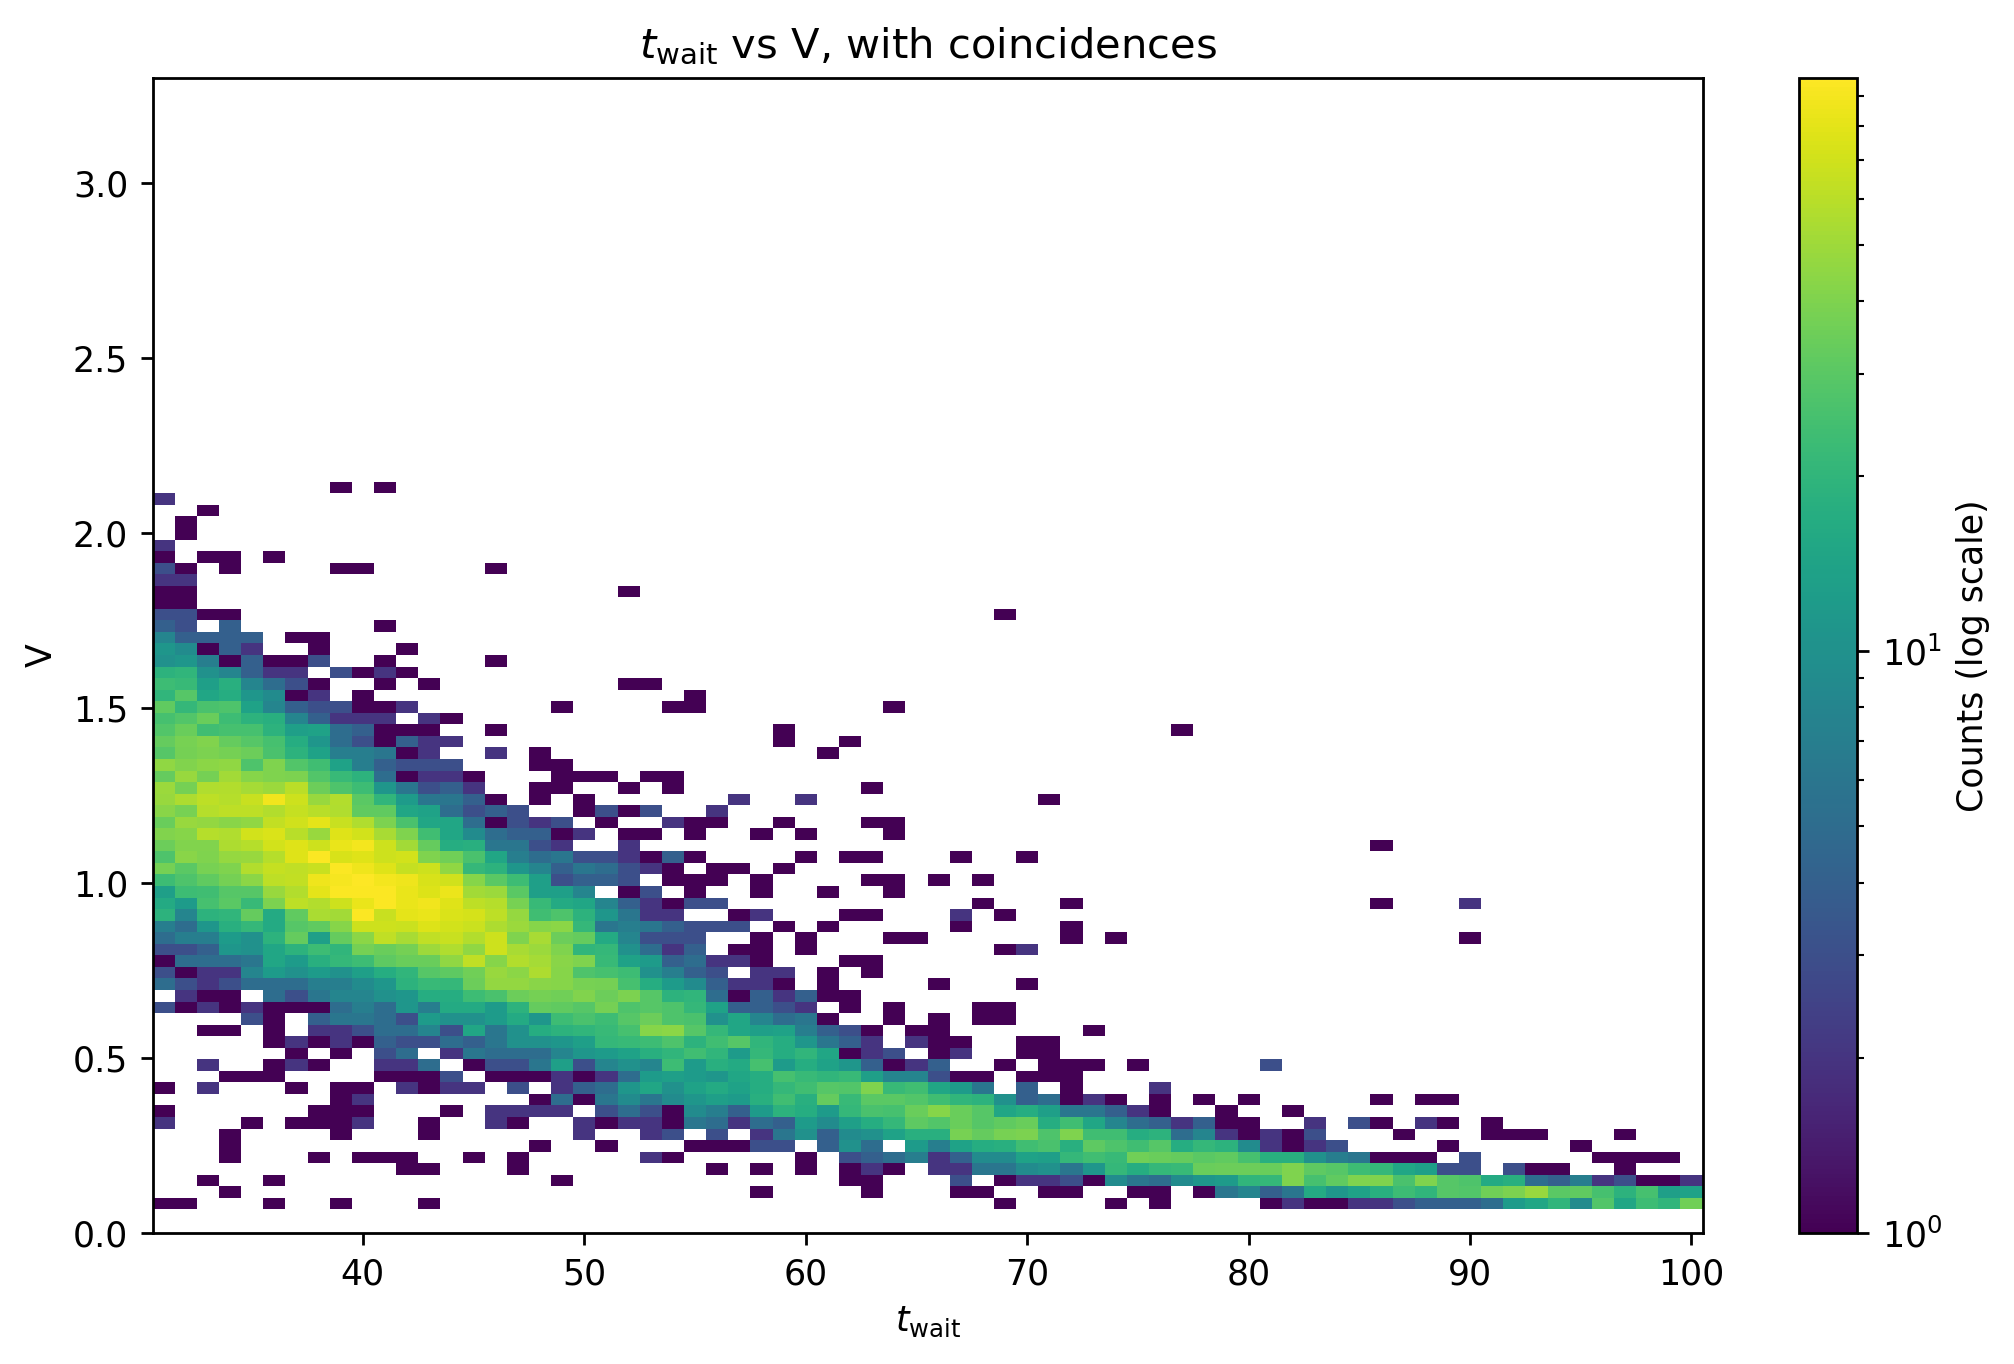

In [47]:
plt.figure(figsize=(10, 6))
tedges = np.linspace(30.5, 100.5, 71)
vedges = np.linspace(0, 3.3, 101)
plt.hist2d(dfcc['wait_cnt'], dfcc['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm())
#plt.hist2d(dfc['t_wait'], dfc['V'], bins=[tedges, vedges],   norm=mcolors.LogNorm(), alpha=0.5)
plt.colorbar(label='Counts (log scale)')
plt.xlabel('$t_\\text{wait}$')
plt.ylabel('V')
plt.title('$t_\\text{wait}$ vs V, with coincidences')
plt.show()

# Rate calculation
Create a new dt column, now in seconds, to allow us to calculate the rate over time for coincidence and non-coincidence files.

In [48]:
# create a new column with the time difference between entries, in seconds
dfcc['dt'] = dfcc.index.to_series().diff().dt.total_seconds()


# the original file had a dt column that was in microsenconds, so we need to convert that to seconds
if 'dt' in df.keys():
    df = df.drop(columns=['dt'])
df['dt'] = df.index.to_series().diff().dt.total_seconds()


In [49]:
df['dt'].head()

ts
2026-01-07 17:46:03+00:00    NaN
2026-01-07 17:46:04+00:00    1.0
2026-01-07 17:46:04+00:00    0.0
2026-01-07 17:46:06+00:00    2.0
2026-01-07 17:46:07+00:00    1.0
Name: dt, dtype: float64

In [50]:
# calculate the average rate from the file
# the rate is the number of muons divided by the total time
# the total time is the last time minus the first time
total_time = (dfcc.index[-1]-dfcc.index[0]).total_seconds()
rate_coinc = len(dfcc)/total_time
print(total_time, rate_coinc)


161475.0 0.17682613407648243


In [51]:
# calculate the average rate from the file
# the rate is the number of muons divided by the total time
# the total time is the last time minus the first time
total_time = (df.index[-1]-df.index[0]).total_seconds()
rate = len(df)/total_time
print(total_time, rate)


161493.0 0.9295697027115727


Text(0.95, 0.85, 'Mean dt: 5.66s')

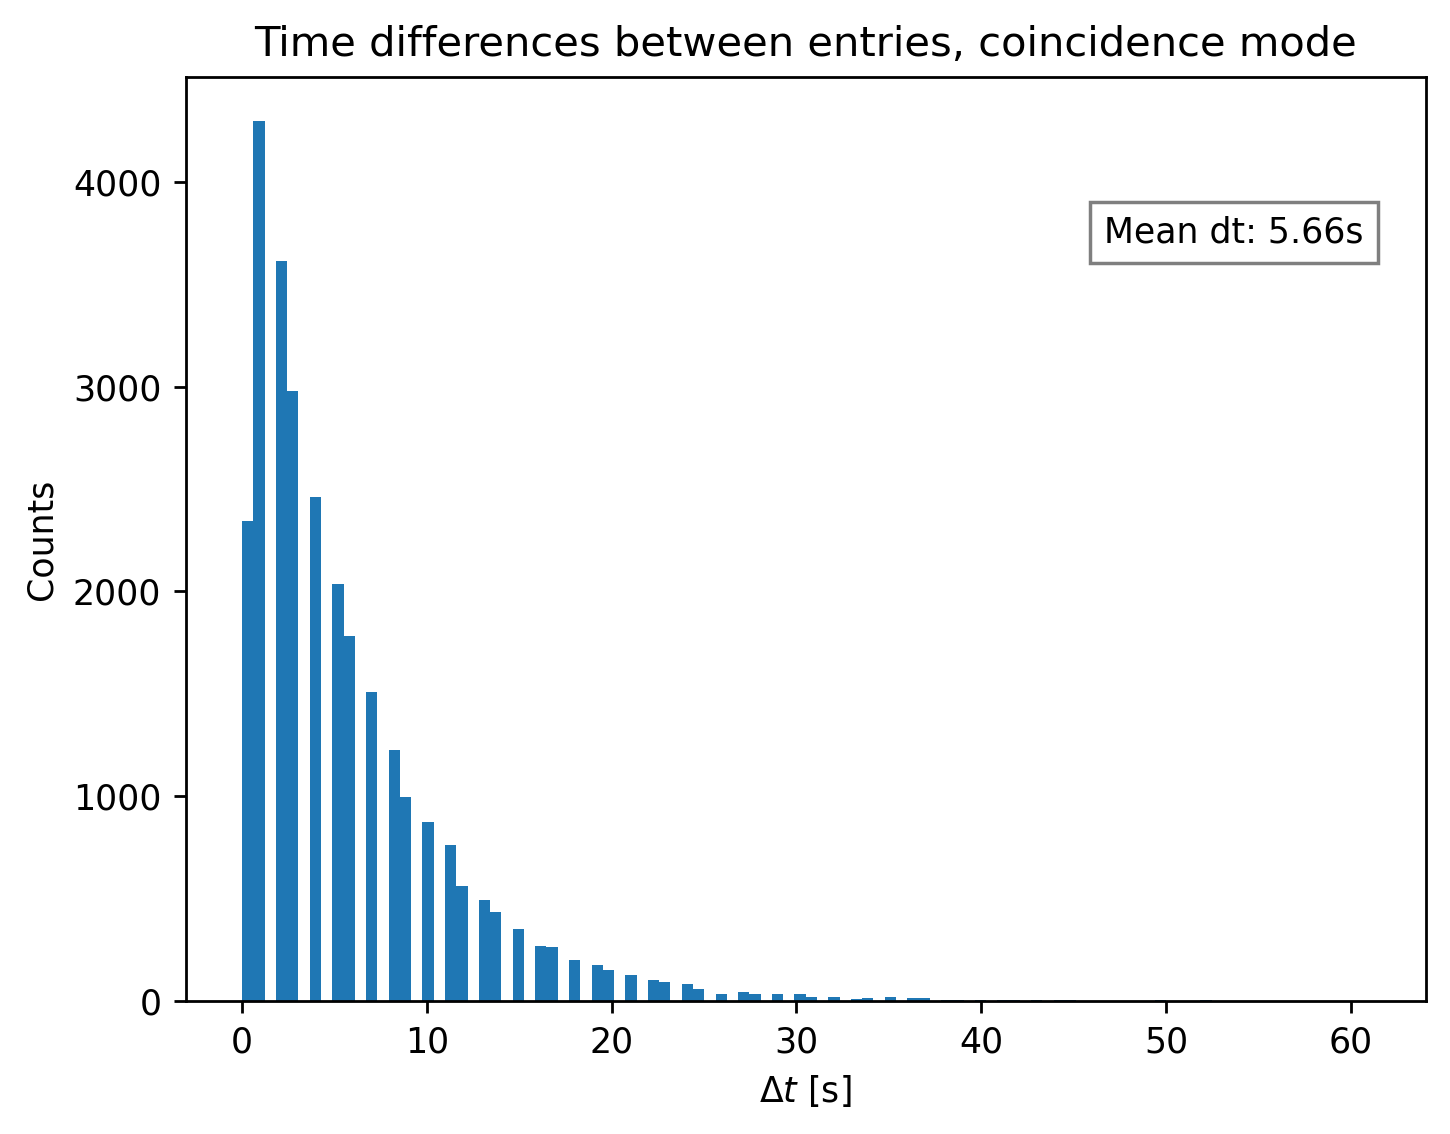

In [52]:
dfcc['dt'].plot.hist(bins=100)
plt.xlabel('$\Delta t$ [s]')
plt.ylabel('Counts')
plt.title('Time differences between entries, coincidence mode')
mean_dt = dfcc['dt'].mean()
plt.text(0.95, 0.85, f'Mean dt: {mean_dt:.2f}s', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

ts
2026-01-07 17:46:03+00:00   NaN
2026-01-07 17:46:04+00:00   NaN
2026-01-07 17:46:04+00:00   NaN
2026-01-07 17:46:06+00:00   NaN
2026-01-07 17:46:07+00:00   NaN
                             ..
2026-01-07 17:47:53+00:00   NaN
2026-01-07 17:47:55+00:00   NaN
2026-01-07 17:47:59+00:00   NaN
2026-01-07 17:48:00+00:00   NaN
2026-01-07 17:48:00+00:00   NaN
Name: rolling_avg_rate, Length: 100, dtype: float64


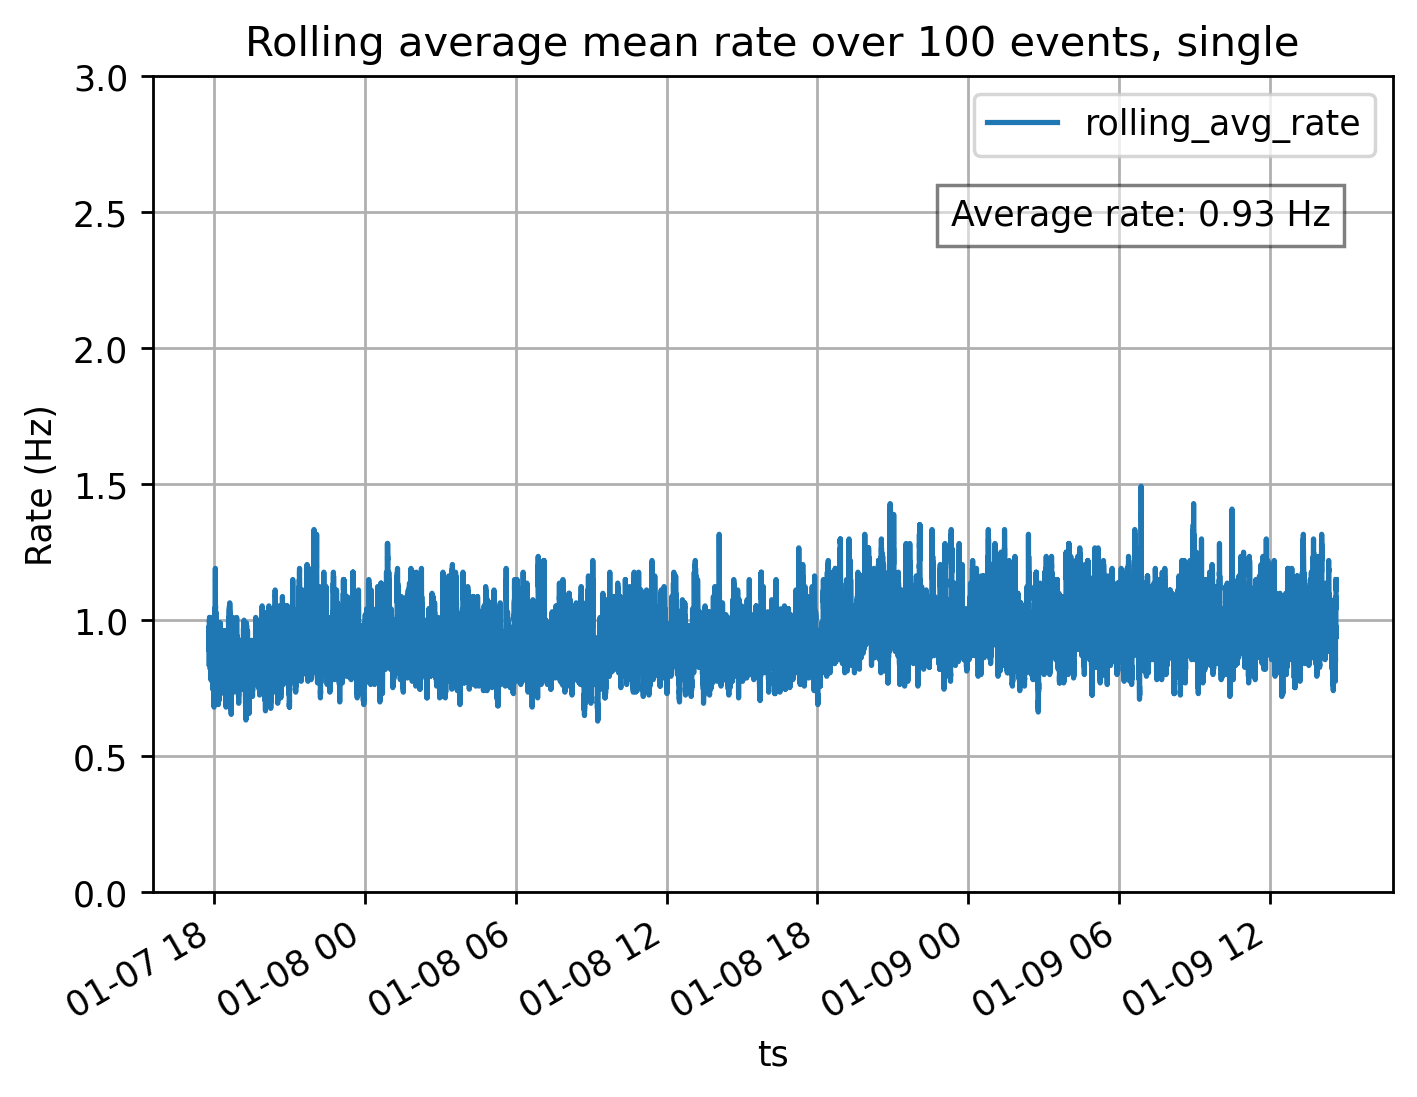

In [53]:
winsize=100
df['rolling_avg_rate'] = 1./(df['dt'].rolling(window=winsize).mean())
df['rolling_avg_rate'].tail()
print(df['rolling_avg_rate'].head(100))
df.dropna(inplace=True)
df['rolling_avg_rate'].plot()
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0,3)
plt.grid()
plt.title(f'Rolling average mean rate over {winsize} events, single')
plt.text(0.95, 0.85, f'Average rate: {rate:.2f} Hz', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.savefig('rolling_avg_rate_single.png')


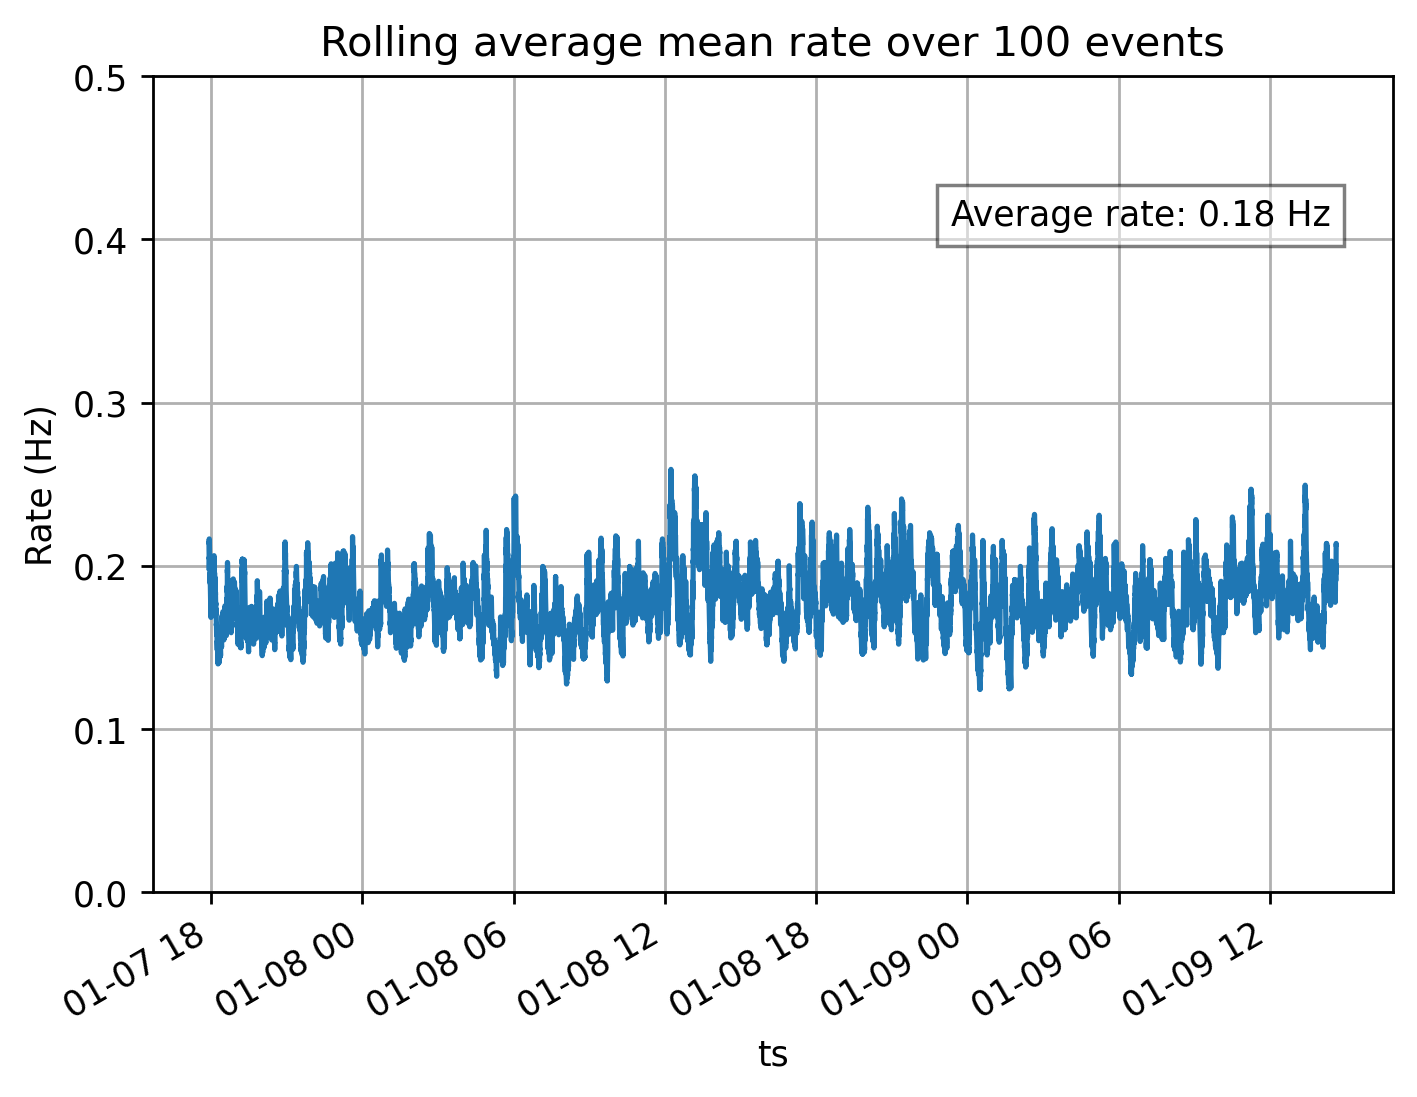

In [54]:
dfcc['rolling_avg_rate'] = 1./(dfcc['dt'].rolling(window=winsize).mean())
dfcc['rolling_avg_rate'].plot()
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0,.5)
plt.grid()
plt.title(f'Rolling average mean rate over {winsize} events')
plt.text(0.95, 0.85, f'Average rate: {rate_coinc:.2f} Hz', 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.savefig('rolling_avg_rate_coinc.png')


Text(0.5, 1.0, 'Rolling average mean rate over 100 events')

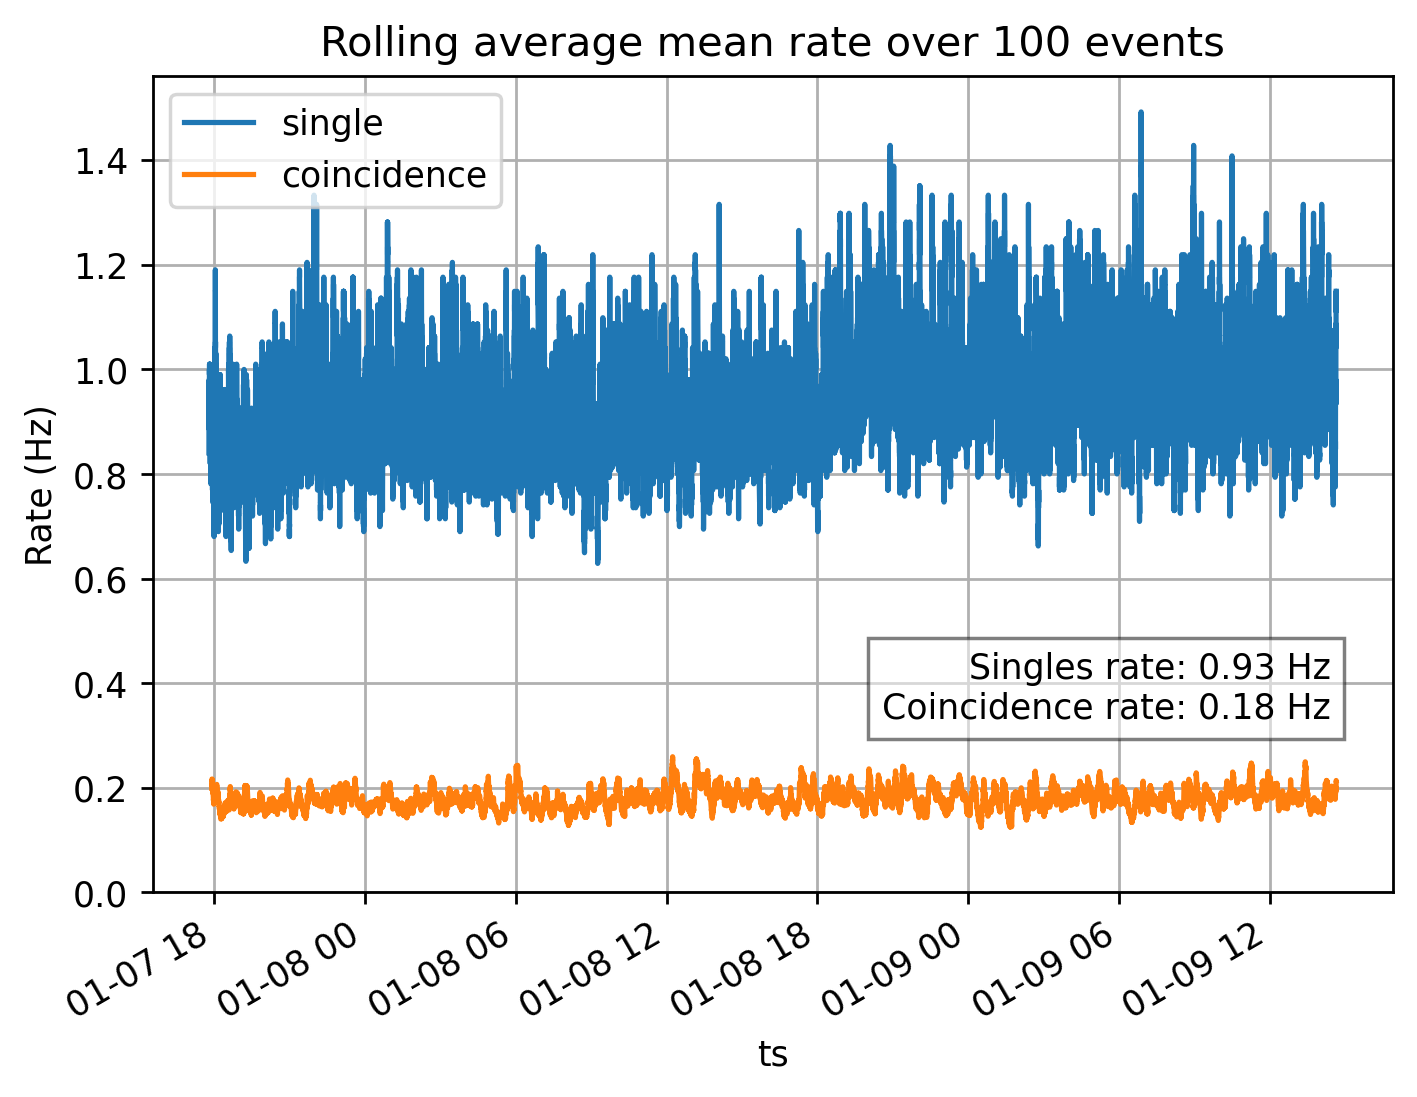

In [55]:
df['rolling_avg_rate'].plot(label='single')
dfcc['rolling_avg_rate'].plot(label='coincidence')
# label y axis as Hz
plt.ylabel('Rate (Hz)')
plt.ylim(0)
plt.grid()
plt.text(0.95, 0.25, f'Singles rate: {rate:.2f} Hz\nCoincidence rate: {rate_coinc:.2f} Hz', 
         horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))
plt.legend()

plt.title(f'Rolling average mean rate over {winsize} events')


Text(0.5, 1.0, 'Temperature vs time')

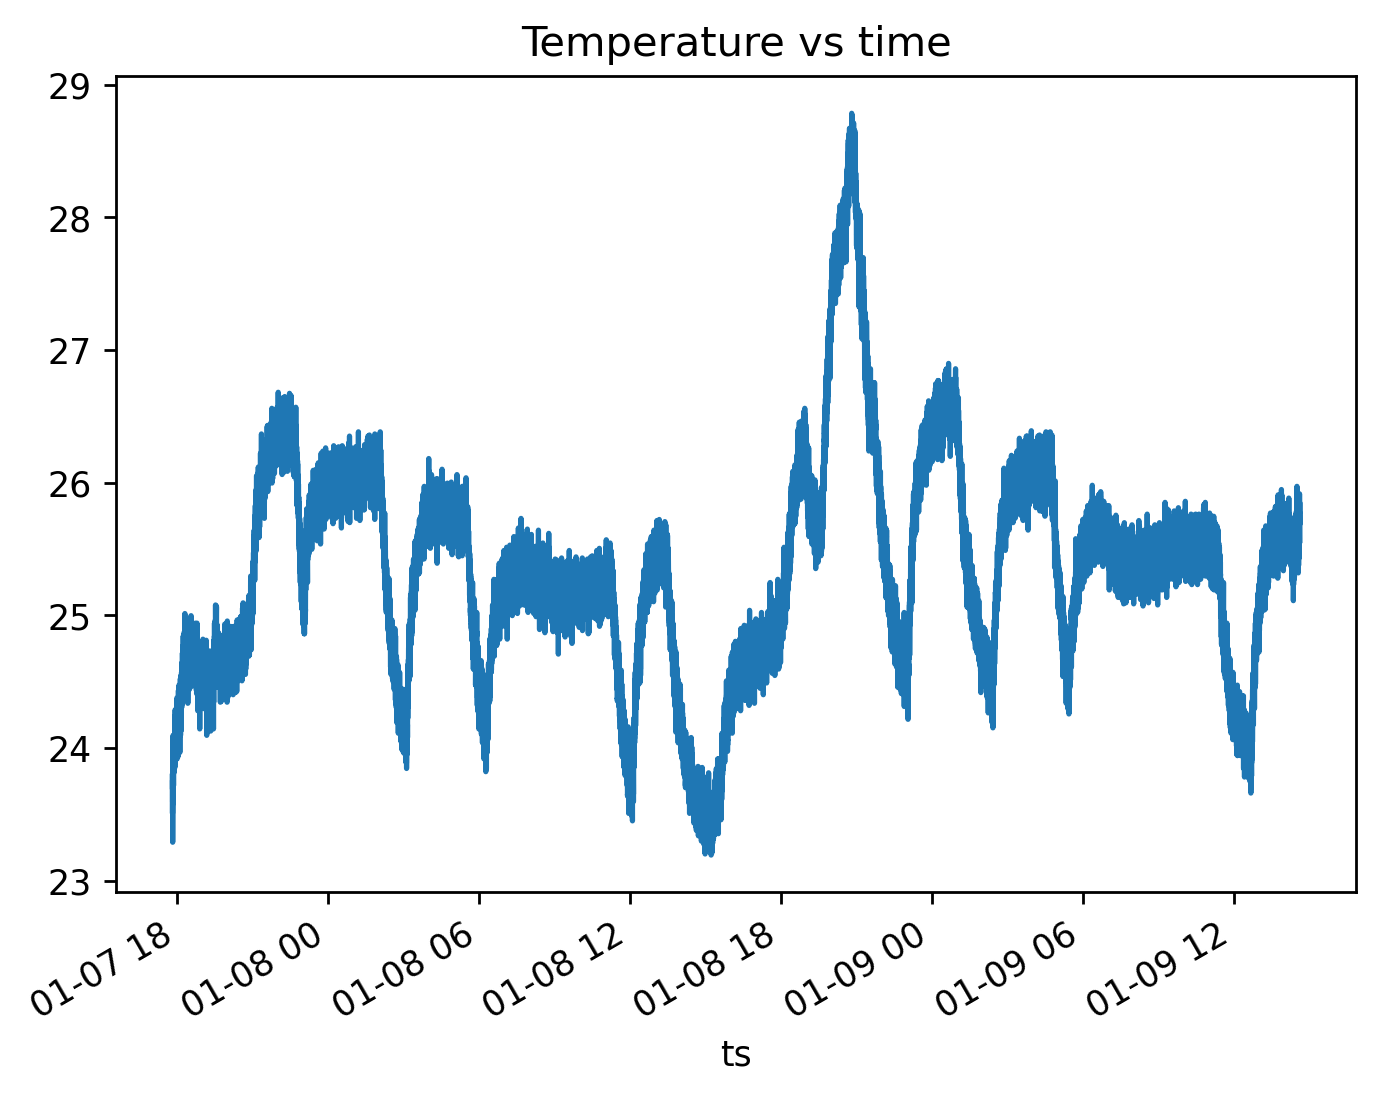

In [56]:
df['TempC'].rolling(window=10).mean().plot()
plt.title('Temperature vs time')